<center><h1>SaShiMi Demo on MNIST</h1></center>

This notebook is intended to test whether our SaShiMi implementation works correctly by running it on MNIST. SaShiMi introduces new layers for down-pooling and up-pooling, which require special handling in recurrent mode.

There are unit tests available in `sashimi_tests.py` file. Run these unit tests with
```bash
python3 -m unittest sashimi_tests.py
```

For a more preliminary introduction to S4, see [S4-MNIST-Demo](https://github.com/necrashter/SaShiMi-796/blob/master/S4-MNIST-Demo.ipynb).

# Prelude

Setup, import modules, select device, etc.

In [1]:
%matplotlib inline
# Built-in IPython extension to reload modules when updated.
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import copy
import IPython.display as ipd

# Custom modules
from S4 import *
from sashimi import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cuda')

# Dataset

In [4]:
# Load dataset
# Use the smaller test set to train faster
MNIST_TEST = datasets.MNIST(root='./../datasets', train=False, download=True, transform=transforms.ToTensor())

dataloader = DataLoader(MNIST_TEST, shuffle=True, batch_size=8)
testloader = DataLoader(MNIST_TEST, shuffle=False, batch_size=1)

# Model

Here we define the model. We won't go into the implementation details in this notebook. See the documentation and comments in the code.

In [5]:
torch.manual_seed(42)

model = SaShiMi(
    input_dim=1,
    hidden_dim=128,
    output_dim=256,
    state_dim=256,
    sequence_length=784,
    block_count=2,
).to(device)

# Overfitting Test

In accordance with the well-respected 796 tradition, we first test whether the model works by trying to overfit into a single example.

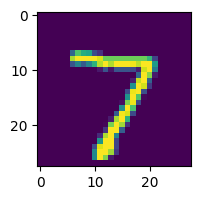

In [6]:
overfit_image = MNIST_TEST[0][0]
plt.figure(figsize=(2,2))
plt.imshow(overfit_image.reshape(28, 28, 1))

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
losses = []

  0%|          | 0/100 [00:00<?, ?it/s]

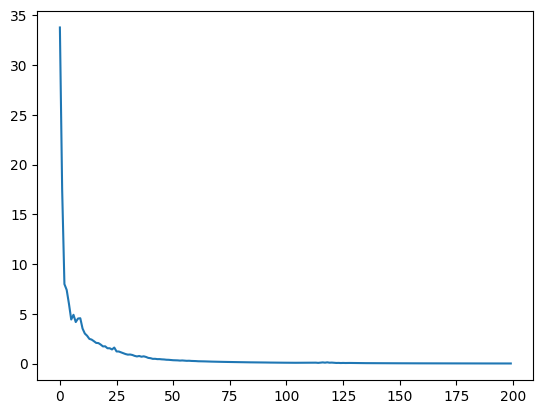

In [18]:
model.train()
for epoch in tqdm(range(100), leave=False):
    train_loss = 0.0
    for img in [overfit_image]:
        # Convert image to a signal with L = 784 and dimension 1
        img = img.to(device).reshape(-1, 784, 1)
        # Shift and pad with zero to generate input
        x = torch.cat([torch.zeros(img.size(0), 1, 1, device=device), img[:, :-1, :]], dim=1)
        # For each sample i, predict the next sample (i+1) from the slice between 0 to i
        y_hat = model(x)
        
        y = torch.mul(img, 255.0).to(torch.int64).to(device)[:,:,0]
        loss = criterion(y_hat.reshape(-1, 256), y.reshape(-1))

        loss_val = loss.detach().cpu().item()
        train_loss += loss_val
        losses.append(loss_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

plt.plot(losses)
plt.show()

## Convolutional Sampling

This one generates each pixel assuming that all previous pixels are predicted correctly, i.e., sample $i$ is predicted from ground truth values of samples $0$ to $i-1$ instead of generated samples.

In [19]:
model.eval()
with torch.no_grad():
    img = overfit_image.to(device).reshape(-1, 784, 1)
    x = torch.cat([torch.zeros(img.size(0), 1, 1, device=device), img[:, :-1, :]], dim=1)
    y_hat = model(x)
    sample = torch.argmax(y_hat, dim=-1)

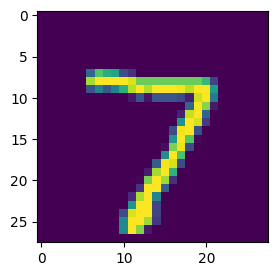

In [20]:
plt.figure(figsize=(3,3))
plt.imshow(sample.cpu().reshape(28, 28, 1))

## Sampling

In [21]:
def generate_sample(m, priming_signal=None, maxp=False):
    f = m.get_recurrent_runner()
    # The input is padded with 0 at the start
    u = f(torch.zeros(1, device=device))

    # Process the priming signal if given
    if priming_signal is not None:
        for s in priming_signal:
            u = f(s)
        primed_size = priming_signal.size(0)
    else:
        primed_size = 0

    # Generate the new part
    Y = []
    for _ in range(784 - primed_size):
        if maxp:
            p = torch.argmax(u)
        else:
            dist = torch.distributions.categorical.Categorical(probs=torch.nn.functional.softmax(u, dim=-1))
            p = dist.sample()
        p = p / 255.0
        Y.append(p)
        u = p.reshape(1)
        u = f(u)

    generated = torch.stack(Y).real
    # Red: generated part
    # Green: given part
    if priming_signal is not None:
        priming_signal = priming_signal.flatten()
        red = torch.cat([torch.zeros_like(priming_signal), generated], dim=0)
        green = torch.cat([priming_signal, torch.zeros_like(generated)], dim=0)
    else:
        red = generated
        green = torch.zeros_like(red)
    blue = torch.zeros_like(green)
    return torch.cat([color.reshape(28, 28, 1) for color in [red, green, blue]], dim=-1)

In [22]:
def overfit_sample(start=0, maxp=False):
    model.eval()
    with torch.no_grad():
        img = overfit_image
        img = img.to(device).reshape(-1, 784, 1)
        sample = generate_sample(model, img[0, :start, :] if start > 0 else None, maxp).cpu()
        plt.figure(figsize=(2,2))
        plt.imshow(sample)

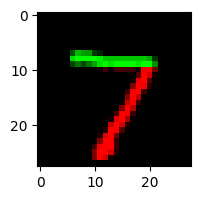

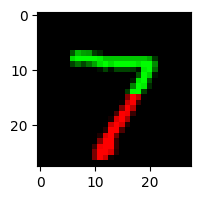

In [23]:
overfit_sample(28*10, maxp=True)
overfit_sample(28*15, maxp=True)

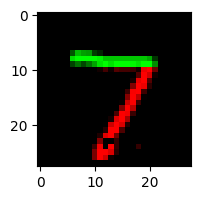

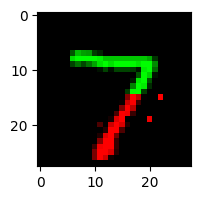

In [24]:
torch.manual_seed(42)
overfit_sample(28*10)
overfit_sample(28*15)

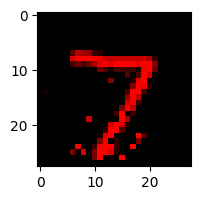

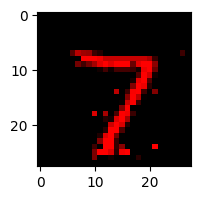

In [25]:
torch.manual_seed(7)
overfit_sample()
overfit_sample()